MLP on MNIST dataset

**MNIST Dataset**


The MNIST dataset of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples each of size 28 x 28 pixels. The digits have been size-normalized and centered in a fixed-size image.


In [ ]:
import time
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F                          # functional api
from torch import optim                                  # optimizers


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt

# display plots in notebook only
%matplotlib inline

In [ ]:
# num of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 20

# percentage of training set to use as validation
val_size = 0.2


# convert data to torch.FloatTensor

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False , download=True, transform=transform)

In [ ]:
# obtain training indices used for validation

num_test = len(test_data)
indices = list(range(num_test))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_test))
test_idx , val_idx  = indices[split:], indices[:split]

# define samples for obtaining training and validation batches
test_sampler = SubsetRandomSampler(test_idx)
val_sampler = SubsetRandomSampler(val_idx)

# dataloader combines dataset and sampler
train_loader = torch.utils.data.DataLoader(train_data,  batch_size=batch_size, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(test_data,  batch_size=batch_size,  sampler=val_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, sampler=test_sampler)


print('Training samples', len(train_loader.dataset))
print('Validation samples', len(val_loader.dataset))
print('Test samples', len(test_loader.dataset))


dataloaders_dict = {'train': train_loader, 'val': val_loader}

Training samples 60000
Validation samples 10000
Test samples 10000


##visualizing data

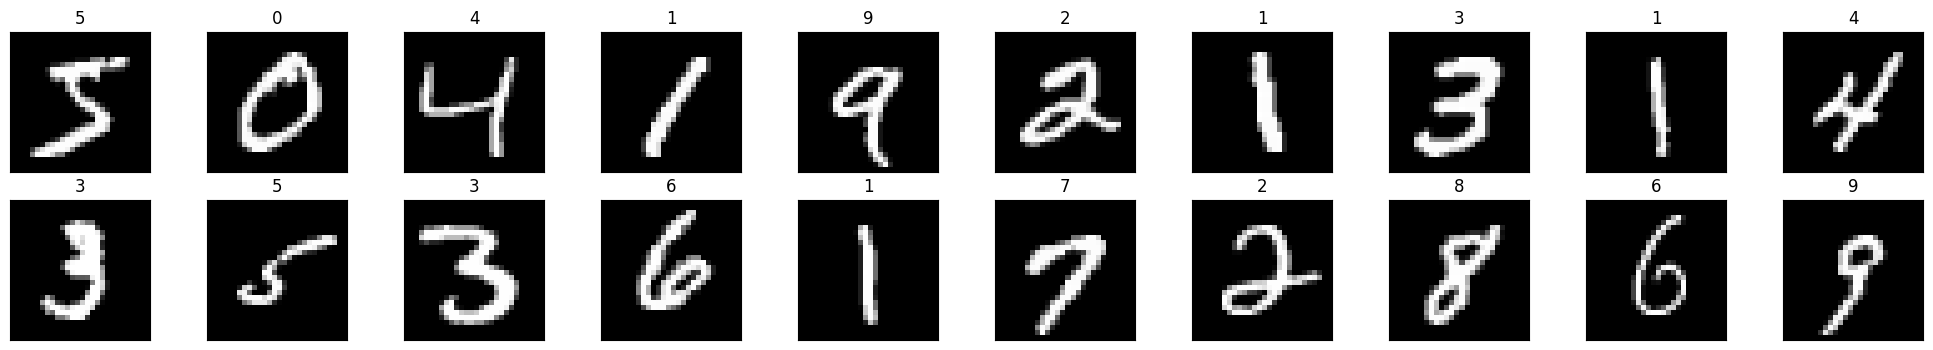

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# single batch of training images

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for index in np.arange(20):
    img = fig.add_subplot(2, 10, index+1, xticks=[], yticks=[])
    img.imshow(np.squeeze(images[index]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    img.set_title(str(labels[index].item()))

## define model

In [ ]:
num_classes = 10
epochs =5

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    num_input_layers = 784
    num_hidden_layers = 16
    num_output_layers = num_classes

    self.classifier = torch.nn.Sequential(
        torch.nn.Linear(num_input_layers, num_hidden_layers),
        torch.nn.ReLU(),
        torch.nn.Linear(num_hidden_layers, num_output_layers),
        torch.nn.LogSoftmax(dim=1)
    )

  def forward(self, x):
    # flatten i/p layer
    x = x.view(-1, 28 * 28)
    x = self.classifier(x)
    return x



model = MLP()
model = model.to(device)
print(model)


MLP(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
    (3): LogSoftmax(dim=1)
  )
)


In [ ]:
loss_fn = nn.NLLLoss()  # -ve log likelyhood loss used for muilticlass classification , o/p log probabilities
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
import copy, time, torch

def train_model(model, dataloaders, loss_fn, optimizer , num_epochs):
  before_time = time.time()

  history = dict()

  best_model_weights = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode  , # Enable dropout, batchnorm, etc.
          else:
              model.eval()   # Set model to evaluate mode  , # disable dropout, batchnorm, etc.

          running_loss = 0.0
          running_corrects = 0


          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  # Get model outputs and calculate loss

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      outputs = model(inputs)
                      loss = loss_fn(outputs, labels)
                      loss.backward()
                      optimizer.step()

                  else:
                      outputs = model(inputs)
                      loss = loss_fn(outputs, labels)

                  _, preds = torch.max(outputs, 1)

              # accuracy calculation
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / (len(dataloaders[phase])*batch_size)
          epoch_acc = running_corrects.double() / (len(dataloaders[phase])*batch_size)

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
          print (len(dataloaders[phase].dataset))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

          if phase+'_acc' in history:
              # append the new number to the existing array at this slot
              history[phase+'_acc'].append(epoch_acc)
          else:
              # create a new array in this slot
              history[phase+'_acc'] = [epoch_acc]

          if phase+'_loss' in history:
              # append the new number to the existing array at this slot
              history[phase+'_loss'].append(epoch_loss)
          else:
              # create a new array in this slot
              history[phase+'_loss'] = [epoch_loss]

  time_elapsed = time.time() - before_time
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_weights)
  return model, history



In [9]:
model, history = train_model(model, dataloaders_dict, loss_fn, optimizer, epochs)


Epoch 0/4
----------
train Loss: 0.3998 Acc: 0.8904
60000
val Loss: 0.2548 Acc: 0.9205
10000
Epoch 1/4
----------
train Loss: 0.2342 Acc: 0.9315
60000
val Loss: 0.2030 Acc: 0.9380
10000
Epoch 2/4
----------
train Loss: 0.1984 Acc: 0.9425
60000
val Loss: 0.1829 Acc: 0.9400
10000
Epoch 3/4
----------
train Loss: 0.1778 Acc: 0.9479
60000
val Loss: 0.1744 Acc: 0.9430
10000
Epoch 4/4
----------
train Loss: 0.1635 Acc: 0.9522
60000
val Loss: 0.1677 Acc: 0.9445
10000
Training complete in 1m 11s
Best val Acc: 0.944500


In [ ]:
history

{'train_acc': [tensor(0.8904, device='cuda:0', dtype=torch.float64),
  tensor(0.9315, device='cuda:0', dtype=torch.float64),
  tensor(0.9425, device='cuda:0', dtype=torch.float64),
  tensor(0.9479, device='cuda:0', dtype=torch.float64),
  tensor(0.9522, device='cuda:0', dtype=torch.float64)],
 'train_loss': [0.39979767160862684,
  0.2342111974437721,
  0.19837656703886267,
  0.1778133421172388,
  0.1634732293811006],
 'val_acc': [tensor(0.9205, device='cuda:0', dtype=torch.float64),
  tensor(0.9380, device='cuda:0', dtype=torch.float64),
  tensor(0.9400, device='cuda:0', dtype=torch.float64),
  tensor(0.9430, device='cuda:0', dtype=torch.float64),
  tensor(0.9445, device='cuda:0', dtype=torch.float64)],
 'val_loss': [0.2547650855779648,
  0.20300494085997342,
  0.18293729808181525,
  0.17439722681883724,
  0.16774958050809802]}

In [ ]:
# convert tensors to numpy arrays

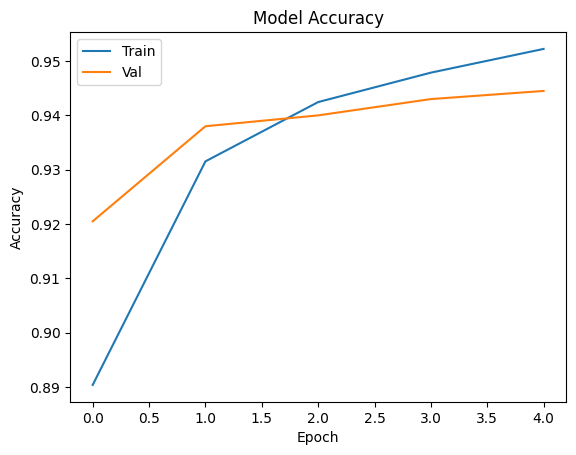

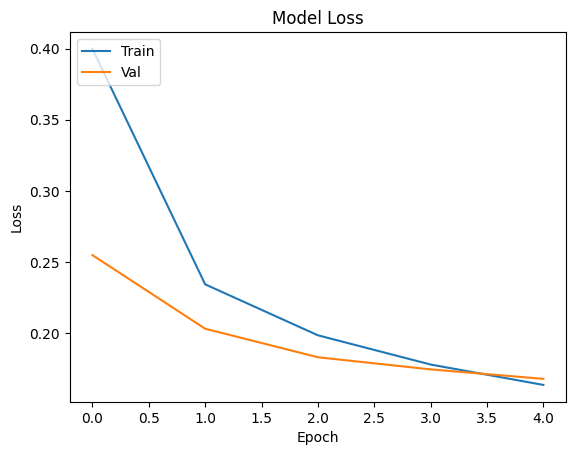

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot([acc.cpu().numpy() if torch.is_tensor(acc) else acc for acc in history['train_acc']])
plt.plot([acc.cpu().numpy() if torch.is_tensor(acc) else acc for acc in history['val_acc']])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [21]:
test_loss = 0.0
true_class = [0 for _ in range(10)]
total_class = [0 for _ in range(10)]

model.eval()

for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)


    output = model(data)
    loss = loss_fn(output, target)
    test_loss += loss.item() * data.size(0)

    _, pred = torch.max(output, 1)
    correct = pred.eq(target.view_as(pred)).cpu().numpy()

    for i in range(len(target)):
        label = target[i].item()
        true_class[label] += correct[i]
        total_class[label] += 1

# Average test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if total_class[i] > 0:
        acc = 100.0 * true_class[i] / total_class[i]
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' %
              (str(i), acc, true_class[i], total_class[i]))
    else:
        print('Test Accuracy of %5s: N/A (no test examples)' % str(i))

# Overall accuracy
total_correct = sum(true_class)
total_samples = sum(total_class)
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' %
      (100.0 * total_correct / total_samples, total_correct, total_samples))


Test Loss: 1.859032

Test Accuracy of     0:  0% ( 0/776)
Test Accuracy of     1:  0% ( 0/919)
Test Accuracy of     2:  0% ( 0/825)
Test Accuracy of     3:  0% ( 0/792)
Test Accuracy of     4:  0% ( 0/784)
Test Accuracy of     5:  5% (38/726)
Test Accuracy of     6:  0% ( 0/767)
Test Accuracy of     7: 96% (769/796)
Test Accuracy of     8:  0% ( 0/797)
Test Accuracy of     9:  0% ( 0/818)

Test Accuracy (Overall): 10% (807/8000)


In [20]:
import numpy as np
import torch

# Set model to evaluation mode
model.eval()

test_loss = 0.0
true_class = [0 for _ in range(10)]
total_class = [0 for _ in range(10)]

# Ensure loss_fn is the same as training: NLLLoss
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)
        loss = loss_fn(output, target)
        test_loss += loss.item() * data.size(0)

        # Get predictions
        _, preds = torch.max(output, 1)

        # Per-class accuracy
        for label, prediction in zip(target, preds):
            total_class[label.item()] += 1
            if label.item() == prediction.item():
                true_class[label.item()] += 1

# Average test loss
test_loss = test_loss / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.6f}\n')

# Per-class accuracy
for i in range(10):
    if total_class[i] > 0:
        acc = 100 * true_class[i] / total_class[i]
        print(f'Test Accuracy of {i:5}: {acc:2.0f}% ({true_class[i]}/{total_class[i]})')
    else:
        print(f'Test Accuracy of {i:5}: N/A (no test examples)')

# Overall accuracy
total_correct = sum(true_class)
total_samples = sum(total_class)
overall_acc = 100. * total_correct / total_samples
print(f'\nTest Accuracy (Overall): {overall_acc:.0f}% ({total_correct}/{total_samples})')


Test Loss: 1.859032

Test Accuracy of     0:  0% (0/776)
Test Accuracy of     1:  0% (0/919)
Test Accuracy of     2:  0% (0/825)
Test Accuracy of     3:  0% (0/792)
Test Accuracy of     4:  0% (0/784)
Test Accuracy of     5:  5% (38/726)
Test Accuracy of     6:  0% (0/767)
Test Accuracy of     7: 97% (769/796)
Test Accuracy of     8:  0% (0/797)
Test Accuracy of     9:  0% (0/818)

Test Accuracy (Overall): 10% (807/8000)


In [18]:
print("Preds:", pred[:10].cpu().numpy())
print("Labels:", labels[:10].cpu().numpy())

Preds: [7 7 7 7 7 7 7 7 7 7]
Labels: [5 0 4 1 9 2 1 3 1 4]


In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # must match training
])


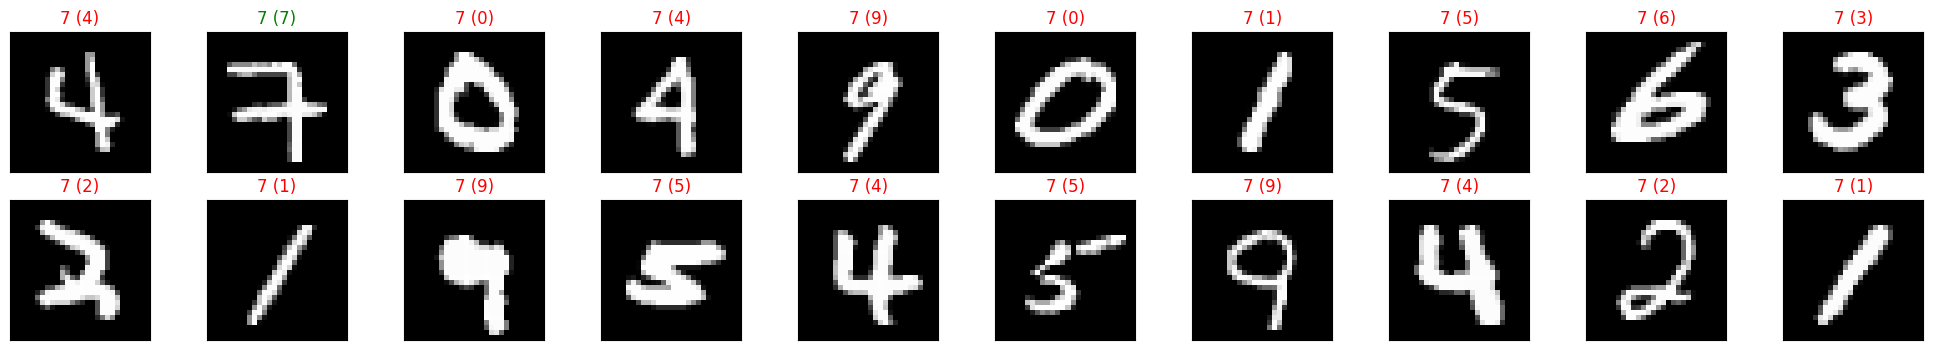

In [23]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)


# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))